In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../models/stylegan2')
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import sklearn.model_selection
import models
import util
import os
import config
import viz
import scipy.stats
from tqdm import tqdm
import figs
import matplotlib.image as mpimg
sys.path.append('transects')
from transects import make_transects, ganwrapper

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/python3/lib/pyt

# look at celeba-hq

0.2058747535026458
0.660261133125997
0.9857338378454609
0.9999999933220884


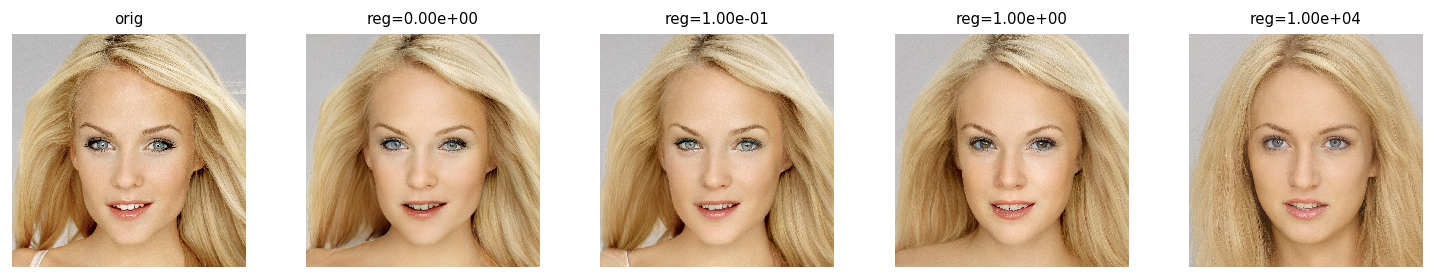

In [3]:
DIR_ORIG = '../data/celeba-hq/ims/'
DIRS_GEN = '../data_processed/celeba-hq/'

regs = [0, 0.1, 1, 10000]
IM_NUMS = np.arange(2, 3)


R, C = len(IM_NUMS), 1 + len(regs)
plt.figure(dpi=120, figsize=(C*2.5, R*2.5))
for r, IM_NUM in enumerate(IM_NUMS):
    ims = []
    latents = []
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{IM_NUM:05}.jpg'))
    for reg in regs:
        folder = f'generated_images_{reg}'
        im_fname = oj(DIRS_GEN, folder, f'{IM_NUM:05}.png')
        ims.append(mpimg.imread(im_fname))
        latents.append(np.load(oj(DIRS_GEN, folder, f'{IM_NUM:05}.npy')))
        print(np.mean(np.abs(np.corrcoef(latents[-1]))))

    
    plt.subplot(R, C, C * r + 1)
    util.imshow(im_orig)
    if r == 0:
        plt.title('orig', fontsize=9)

    for i in range(len(regs)):
        plt.subplot(R, C, C * r + 2 + i)
        util.imshow(ims[i])
        if r == 0:
            plt.title(f'reg={regs[i]:.2e}', fontsize=9)
plt.tight_layout()

# now let's regenerate the images

In [4]:
latents = np.array(latents)
print(latents.shape)

(4, 18, 512)


In [5]:
G = ganwrapper.GANWrapper(image_size=512)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [6]:
# make CHG transects
make_transects.make_transects(
                   G,
                   orth=True,
                   save_dir='results/tnew',
                   model_dir="transects/data/latent-models/",
#                    randomize_seeds=True,
# )
                   latents=latents)

0 4


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.ridge module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Ridge from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklear

1 4
2 4
3 4


In [7]:
# make 1D transects
LIMS = {
    'C': [-1.5, 1.7],
    'H': [-0.5, 0.0],
    'G': [-1.75, 1.75],
}
N_IMS = 5
ATTRS = 'CHG'
for attr in ATTRS:
    make_transects.make_transects(
                       G,
                       attr=attr,
                       N_IMS_LIST=[N_IMS],
                       LIMS_LIST=LIMS[attr],
                       orth=True,
                       save_dir='results/t1d',
                       model_dir="transects/data/latent-models/",
                       latents=latents)

0 4
1 4
2 4
3 4
0 4
1 4
2 4
3 4
0 4
1 4
2 4
3 4


**load the results**

In [ ]:
results_dir = 'results/t1d'
for im_num in tqdm([1]): # pick the best reg #range(N_IMS)):
    ims = []
    for attr in ATTRS:
        for im_variation_num in range(N_IMS):
            ims.append(mpimg.imread(oj(results_dir, 'ims', f'{im_num:04d}_{attr}{im_variation_num}.jpg')))
    ims = np.array(ims)
    ims = ims.reshape(len(ATTRS), N_IMS, *ims.shape[1:]) 
    util.plot_grid(ims, ylabs=[config.LABELS[a] for a in ATTRS])
    os.makedirs(oj(results_dir, 'out'), exist_ok=True)
    plt.savefig(oj(results_dir, 'out', f'{im_num}.jpg'))
    plt.show()

# let's just look at a bunch of reconstructions
(at the best reg)

In [15]:
DIR_ORIG = '../data/celeba-hq/ims/'
DIRS_GEN = '../data_processed/celeba-hq/'

reg = 0.1
IM_NUMS = np.arange(30, 60)

ims_orig = []
ims_rec = []
for IM_NUM in IM_NUMS:
    folder = f'generated_images_{reg}'
    im_fname = oj(DIRS_GEN, folder, f'{IM_NUM:05}.png')
    ims_orig.append(mpimg.imread(oj(DIR_ORIG, f'{IM_NUM:05}.jpg')))
    ims_rec.append(mpimg.imread(im_fname))

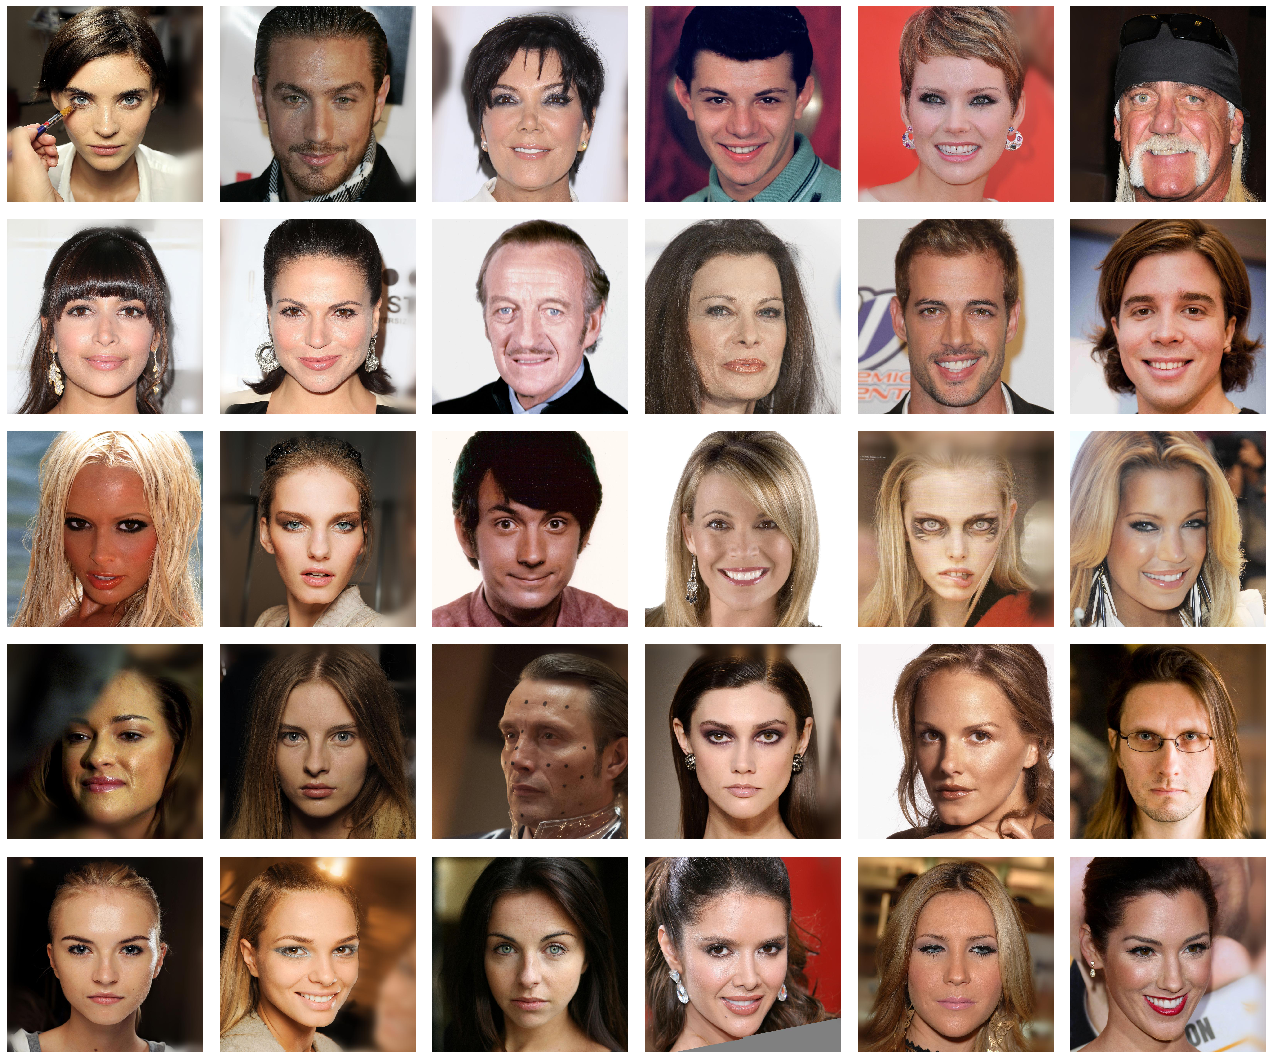

In [16]:
util.plot_grid(ims_orig)

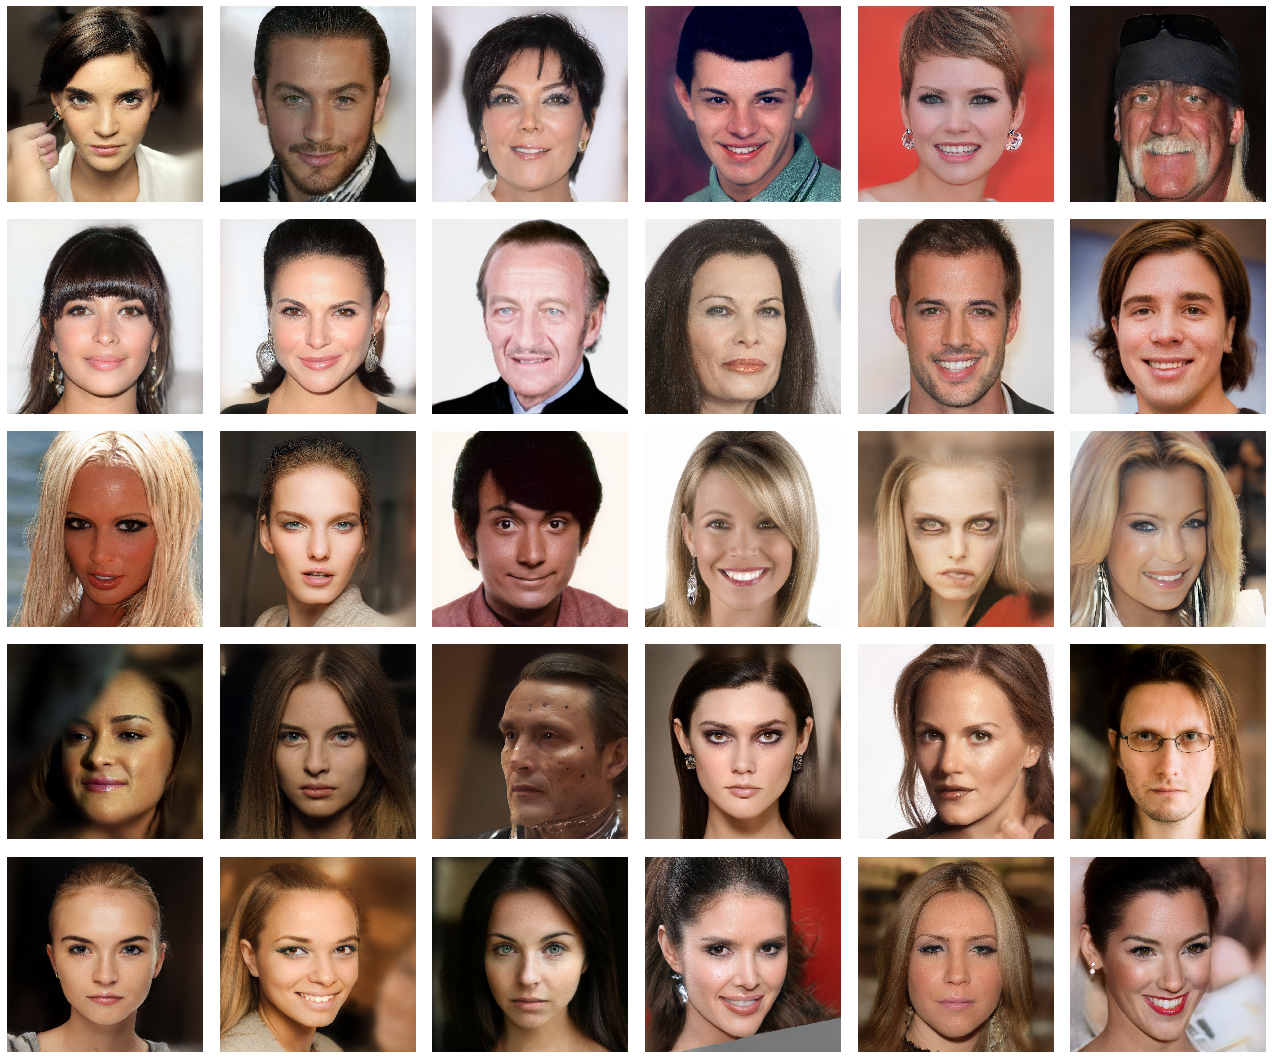

In [17]:
util.plot_grid(ims_rec)

### 